In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


In [2]:
#df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data_Population_Normalized.csv")
df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data.csv")

In [3]:
print(df.columns)
print(df.shape)

Index(['week_no', 'iso_code', 'new_cases', 'new_deaths', 'new_vaccinations',
       'new_people_vaccinated', 'reproduction_rate', 'stringency_index',
       'excess_mortality', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'female_smokers', 'male_smokers', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'population'],
      dtype='object')
(41184, 21)


In [4]:

df.drop(["iso_code", "week_no"], axis=1, inplace=True)
#df.drop(columns=df.columns[0:1], axis=1, inplace=True)
pop = df.iloc[0]["population"]
last_country = df.iloc[234*176 - 1]
print(last_country)
cnt = df["population"].value_counts()

new_cases                     7.500000e+01
new_deaths                    2.000000e+00
new_vaccinations              0.000000e+00
new_people_vaccinated         0.000000e+00
reproduction_rate             9.500000e-01
stringency_index              8.796000e+01
excess_mortality             -1.000000e+03
population_density            4.272900e+01
median_age                    1.960000e+01
aged_65_older                 2.822000e+00
aged_70_older                 1.882000e+00
cardiovasc_death_rate         3.078460e+02
diabetes_prevalence           1.820000e+00
female_smokers                1.600000e+00
male_smokers                  3.070000e+01
hospital_beds_per_thousand    1.700000e+00
life_expectancy               6.149000e+01
human_development_index       5.710000e-01
population                    1.632054e+07
Name: 41183, dtype: float64


In [5]:
# now we want to join datas together
prediction_days_count = 2
features_list = []
X_list = []
Y_list = []

for i in range(234):  # 234 is number of countries
    for j in range(176):  # 176 is number of weeks we have
        row_list = df.loc[i * 176 + j, :].values.flatten().tolist()
        features_list.append(row_list)

for i in range((len(features_list) - prediction_days_count) + 1):
    fl = features_list[i]
    fl_len = len(features_list[i])
    this_population = features_list[i][fl_len - 1]
    for j in range(1, prediction_days_count):
        if this_population == features_list[i + j][fl_len - 1]:
            fl.extend(features_list[i + j])
        else:
            this_population = -1
            break
    if this_population != -1:
        X_list.append(fl)
        Y_list.append(features_list[(i + prediction_days_count) - 1][0])


In [6]:
print(len(X_list))
print(len(Y_list))
np.shape(X_list)

40950
40950


(40950, 38)

In [7]:
# Here we are going to normalize the data.
from sklearn import preprocessing
x_df = pd.DataFrame(X_list)
min_max_scaler_X = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_X.fit_transform(x_df)

y_df = pd.DataFrame(Y_list)
min_max_scaler_Y = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler_Y.fit_transform(y_df)

X_scaled_list = x_scaled.tolist()
Y_scaled_list = y_scaled.tolist()

#df = pd.DataFrame(x_scaled)

In [8]:
import math

def train_test_splitter(X, Y, prediction_days_count, batch_count, batch_length):
    xlen = len(X)
    xs_count_for_each_country = int(xlen / 234)
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    steps = math.floor((xs_count_for_each_country - (batch_count * batch_length)) / (batch_count + 1)) 
    i = 0
    for i in range(234):
        j = 0
        for j in range((i * xs_count_for_each_country), (i * xs_count_for_each_country) + steps):
            X_train.append(X[j])
            Y_train.append(Y[j])
        while(j + batch_length + steps < (i+1) * xs_count_for_each_country):
            for k in range(j + prediction_days_count, j + batch_length - prediction_days_count):
                X_test.append(X[k])
                Y_test.append(Y[k])
            j += batch_length
            for k in range(j, j + steps):
                X_train.append(X[k])
                Y_train.append(Y[k])
            j += steps + 1
            while j < (i+1) * xs_count_for_each_country:
                X_train.append(X[j])
                Y_train.append(Y[j])
                j += 1
    return X_train, X_test, Y_train, Y_test
        

In [9]:
X_train, X_test, Y_train, Y_test = train_test_splitter(X_scaled_list, Y_scaled_list, prediction_days_count, 3, 10)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [11]:
print("X_train:", np.shape(X_train),
      ",X_val:" , np.shape(X_val),
      ",X_test:", np.shape(X_test),

      ",Y_train:" ,np.shape(Y_train),
      ",Y_val:", np.shape(Y_val),
      ",Y_test:", np.shape(Y_test)
      )

X_train: (30888, 38) ,X_val: (7722, 38) ,X_test: (1404, 38) ,Y_train: (30888, 1) ,Y_val: (7722, 1) ,Y_test: (1404, 1)


In [14]:
X_tr = np.array(X_train)
y_tr = np.array(Y_train)
X_te = np.array(X_test)
y_te = np.array(Y_test)
X_val = np.array(X_val)
y_val = np.array(Y_val)

In [15]:
# Rescale predictions and true values back to original scale
def rescale_data(scaler, data):
    return scaler.inverse_transform(np.array(data).reshape(-1, 1)).flatten()

# Loss functions

In [71]:
def mean_square_error_sqrt (y_test, y_pred):
    return np.sqrt(np.sum(np.power(y_test - y_pred, 2)))/len(y_test)
def mean_absolute_error_self_defined (y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

# Modelling

## Importing loss functions

In [54]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error, mean_squared_error, d2_tweedie_score

## Model Evaluation

In [72]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scaler, model_name):
    y_pred_scaled = model.fit(X_train, y_train).predict(X_test)
    y_pred = rescale_data(scaler, y_pred_scaled)
    y_test_rescaled = rescale_data(scaler, y_test)

    # deviding by 10:
    y_pred /= 10
    y_test_rescaled /= 10

    
    mae = mean_absolute_error_self_defined (y_test_rescaled, y_pred)
    mse = mean_square_error_sqrt(y_test_rescaled, y_pred)
    # mape = mean_absolute_percentage_error(y_test_rescaled, y_pred)
    # rmse = mean_squared_error(y_test_rescaled, y_pred, squared=False)

    print(f"Evaluating {model_name}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    # print(f"MAPE: {mape}")
    # print(f"RMSE: {rmse}")
    # print(y_test_rescaled.type)
    print()
    print("Y_test:")
    print(y_test_rescaled[:10])
    print("Y_pred:")
    print(y_pred[:10])
    # plt.figure(figsize=(12, 6))
    # plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted')
    # plt.plot(np.arange(len(y_pred)), y_test_rescaled, alpha=0.6, label='True')
    # plt.title(f"{model_name} Predictions vs True Values")
    # plt.legend()
    # plt.show()

## SVR

In [18]:
from sklearn.svm import SVR

In [73]:
# Train and evaluate SVR models
svrs = [SVR(kernel="rbf", C=50, gamma=0.9, epsilon=0.001),
        SVR(kernel="linear", C=100, gamma="auto"),
        SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)]

for svr in svrs:
    evaluate_model(svr, X_tr, y_tr, X_val, y_val, min_max_scaler_Y, model_name=f"SVR ({svr.kernel})")


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluating SVR (rbf)
MAE: 2122.8071131672
MSE: 29.14535380195715

Y_test:
[3.6000e+00 7.2198e+03 3.3600e+01 6.3500e+01 3.1400e+01 3.8900e+01
 0.0000e+00 9.4700e+01 7.4700e+01 2.1166e+03]
Y_pred:
[ 1123.88841862  5163.17726777 -1691.07791568  -643.97556179
  3111.55648299  3058.71310399  4361.75938726  -521.22916114
  3885.20390206   163.85044334]
Evaluating SVR (linear)
MAE: 365722.61278746766
MSE: 4168.55642643325

Y_test:
[3.6000e+00 7.2198e+03 3.3600e+01 6.3500e+01 3.1400e+01 3.8900e+01
 0.0000e+00 9.4700e+01 7.4700e+01 2.1166e+03]
Y_pred:
[355828.30601368 361783.57512217 354629.86934515 352732.94632298
 354006.14206793 352966.04225924 355557.55798956 354642.59763548
 404475.90866182 354417.86592506]
Evaluating SVR (poly)
MAE: 374298.71716227836
MSE: 4264.215360112589

Y_test:
[3.6000e+00 7.2198e+03 3.3600e+01 6.3500e+01 3.1400e+01 3.8900e+01
 0.0000e+00 9.4700e+01 7.4700e+01 2.1166e+03]
Y_pred:
[363967.94169601 369643.19816452 362987.60584412 361339.21074755
 362548.01015467 369357

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## KNN

In [42]:
from sklearn.neighbors import KNeighborsRegressor

In [48]:
# Train and evaluate KNeighborsRegressor model
neigh = KNeighborsRegressor(n_neighbors=2, p=2)
evaluate_model(neigh, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="KNeighborsRegressor")


Evaluating KNeighborsRegressor
MAE: 5066.817307692308
MAPE: 1.3687863482845712e+17
RMSE: 17882.71698385167
Loss: 319.791566724537

Y_test:
[ 273.  105.  406.  438.  627.  657.  972.  920. 1101. 1435.]
Y_pred:
[ 168.5  286.5  924.5  137.5  137.5  226.5 2089.5 1331.  3867.  3867. ]


## Polynomial

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR

In [23]:
poly = PolynomialFeatures(degree=2)
X_poly_tr = poly.fit_transform(X_tr)
X_poly_te = poly.transform(X_te)

linear_model = LinearSVR(dual="auto", random_state=42)
evaluate_model(linear_model, X_poly_tr, y_tr, X_poly_te, y_te, min_max_scaler_Y, model_name="Polynomial Regression")

InvalidParameterError: The 'dual' parameter of LinearSVR must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int'. Got 'auto' instead.

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

In [24]:
# Train and evaluate AdaBoostRegressor model
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="AdaBoostRegressor")

NameError: name 'AdaBoostRegressor' is not defined

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor

C:\Users\Mohammad erfan\AppData\Local\Temp\ipykernel_15608\3933673566.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  y_pred_scaled = model.fit(X_train, y_train).predict(X_test)


Evaluating RandomForestRegressor
MAE: 4559.94712099512
MAPE: 2.078667831389166e+18
RMSE: 7510.454963440694



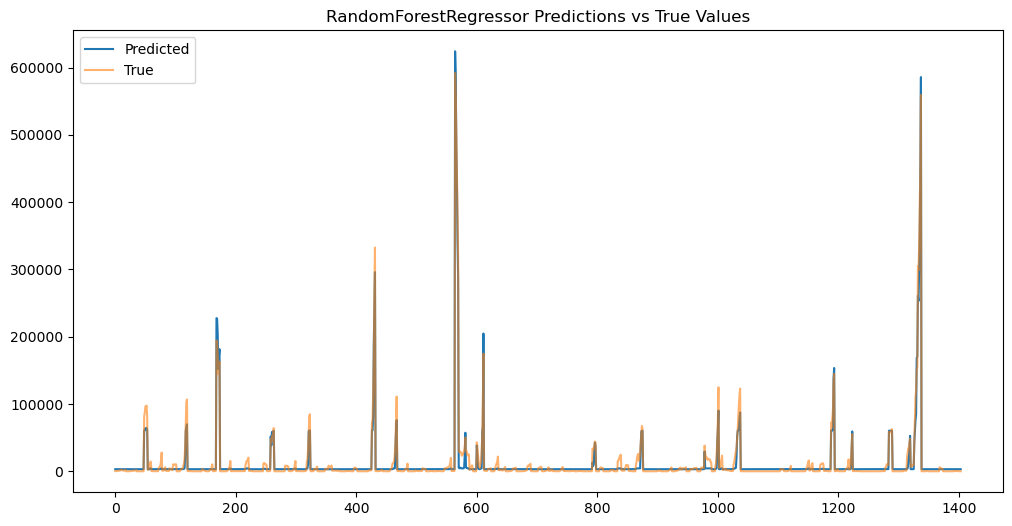

In [26]:
# Train and evaluate RandomForestRegressor model
regr = RandomForestRegressor(max_depth=4, random_state=0)
evaluate_model(regr, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="RandomForestRegressor")

## Stacking

In [27]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

In [28]:
# Train and evaluate StackingRegressor model
estimators = [('lr', RidgeCV()), ('svr', LinearSVR(dual="auto", random_state=42))]
reg = StackingRegressor(estimators=estimators,
                        final_estimator=RandomForestRegressor(n_estimators=10, random_state=42))
evaluate_model(reg, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name="StackingRegressor")

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:957: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


InvalidParameterError: The 'dual' parameter of LinearSVR must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int'. Got 'auto' instead.

In [ ]:
#check to see if my rescaling is working as intended

# Test scaling and rescaling
sample_y = [y_scaled[0], y_scaled[10], y_scaled[100]]
print("Sample scaled values:", sample_y)

rescaled_y = rescale_data(min_max_scaler_Y, sample_y)
print("Rescaled values:", rescaled_y)

original_y = [Y_list[0], Y_list[10], Y_list[100]]
print("Original values:", original_y)

# Check if rescaled values match the original values
print("Match:", np.allclose(rescaled_y, original_y))

# TEST

In [27]:
# ns_list, train_scores, validation_scores = learning_curve(
#                                                    estimator = SVR(**opt_svr_param), 
#                                                    X = X, y = Y, 
#                                                    train_sizes = ns_list, cv = 5,
#                                                    scoring = 'neg_mean_squared_error')


In [28]:
# train_scores, valid_scores = validation_curve(KNeighborsRegressor(), X, Y, 
#                                               param_name="n_neighbors",
#                                               param_range=k_list , cv=20, 
#                                               scoring = 'neg_mean_squared_error',
#                                               verbose=1, n_jobs=-1
#                                              )
